In [2]:
import numpy as np

# =============================================================================
# 对方代码中的常量和基础函数
# =============================================================================

# --- 1) 题面常量 ---
MISSILE_POS0 = np.array([20000.0, 0.0, 2000.0], dtype=float)
MISSILE_SPEED = 300.0
MISSILE_TARGET_FAKE = np.array([0.0, 0.0, 0.0], dtype=float)
MISSILE_DIR = (MISSILE_TARGET_FAKE - MISSILE_POS0) / np.linalg.norm(MISSILE_TARGET_FAKE - MISSILE_POS0)

# 关键差异点：对方将真目标简化为底面圆心一个点
TRUE_TARGET = np.array([0.0, 200.0, 0.0], dtype=float)

UAV_POS0 = np.array([17800.0, 0.0, 1800.0], dtype=float)
G = 9.8
R = 10.0
SINK = 3.0
VALID = 20.0
DT = 0.05 # 对方使用的模拟步长

# --- 2) 基础函数 ---
def missile_pos(t: float) -> np.ndarray:
    """时刻 t 导弹位置"""
    return MISSILE_POS0 + MISSILE_SPEED * t * MISSILE_DIR

def cloud_center(t: float, det_pos: np.ndarray, t_det: float) -> np.ndarray:
    """时刻 t 云团中心 (仅当 t_det <= t <= t_det+VALID 有意义)"""
    return det_pos - np.array([0, 0, 1.0]) * SINK * (t - t_det)

def point_to_segment_dist(p1: np.ndarray, p2: np.ndarray, c: np.ndarray) -> float:
    """点 c 到线段 p1-p2 的最短距离"""
    v = p2 - p1
    w = c - p1
    denom = float(np.dot(v, v))
    if denom == 0.0:
        return float(np.linalg.norm(c - p1))
    s = float(np.dot(w, v) / denom)
    s = 0.0 if s < 0.0 else (1.0 if s > 1.0 else s)
    closest = p1 + s * v
    return float(np.linalg.norm(c - closest))

def detonation_state(theta: float, v: float, t_rel: float, dly: float):
    """由航向 theta、速度 v、投放时刻 t_rel、引信延时 dly 计算:
    - 起爆位置 det_pos (水平匀速、竖直自由落体)
    - 起爆时刻 t_det
    """
    u = np.array([np.cos(theta), np.sin(theta), 0.0], dtype=float)
    rel_pos = UAV_POS0 + v * t_rel * u
    det_pos = rel_pos + v * dly * u
    det_pos[2] = rel_pos[2] - 0.5 * G * (dly ** 2)
    t_det = t_rel + dly
    return t_det, det_pos

def union_coverage(schedule, dt=DT):
    """计算给定起爆日程 schedule = [(t_det, det_pos),...] 的联合遮蔽
    时长与区间。
    遮蔽判据: 导弹-真目标连线到云团中心的最短距离 <= R。
    """
    if not schedule:
        return 0.0, []

    t_start = min([t for t, _ in schedule])
    t_end = max([t for t, _ in schedule]) + VALID
    t_vals = np.arange(t_start, t_end + dt, dt)

    covered = np.zeros_like(t_vals, dtype=bool)
    for i, t in enumerate(t_vals):
        dmin = np.inf
        active = False
        for t_det, pos in schedule:
            if t_det <= t <= t_det + VALID:
                active = True
                M = missile_pos(t)
                C = cloud_center(t, pos, t_det)
                d = point_to_segment_dist(M, TRUE_TARGET, C) # 使用对方的单点目标
                if d < dmin:
                    dmin = d
        covered[i] = active and (dmin <= R)

    # 将 0/1 序列转为时间区间
    x = covered.astype(int)
    dx = np.diff(x)
    entries = t_vals[1:][dx == 1]
    exits = t_vals[1:][dx == -1]

    if len(entries) > len(exits):
        exits = np.append(exits, t_vals[-1])
    if len(entries) < len(exits):
        entries = np.insert(entries, 0, t_vals[0])

    intervals = list(zip(entries, exits))
    total = float(sum(e - s for s, e in intervals))
    return total, intervals

# =============================================================================
# 封装成与我们接口一致的函数，用于对拍
# =============================================================================

def calculate_their_total_coverage(params):
    """
    这是对方代码求解逻辑的等价核心计算函数。
    它接收和我们一样的8个决策变量，返回总遮蔽时长。
    """
    v_FY1, theta_rad, t_drop1, t_fuse1, dt_drop2, t_fuse2, dt_drop3, t_fuse3 = params

    # 从变换后的变量还原真实的投放时间
    t_drop2 = t_drop1 + dt_drop2
    t_drop3 = t_drop2 + dt_drop3

    # 构建对方函数需要的 schedule 列表
    schedule = []

    # 弹药1
    t_det1, pos1 = detonation_state(theta=theta_rad, v=v_FY1, t_rel=t_drop1, dly=t_fuse1)
    schedule.append((t_det1, pos1))

    # 弹药2
    t_det2, pos2 = detonation_state(theta=theta_rad, v=v_FY1, t_rel=t_drop2, dly=t_fuse2)
    schedule.append((t_det2, pos2))

    # 弹药3
    t_det3, pos3 = detonation_state(theta=theta_rad, v=v_FY1, t_rel=t_drop3, dly=t_fuse3)
    schedule.append((t_det3, pos3))

    # 调用对方的核心计算引擎
    total_length, _ = union_coverage(schedule)

    return total_length

# --- 使用示例 ---
if __name__ == '__main__':
    # 使用我们之前找到的最优解作为例子
    v_opt = 70# 假设值
    theta_opt_deg = 176.5 # 假设值
    theta_opt_rad = np.deg2rad(theta_opt_deg)

    t_drop1 = 0
    t_fuse1 = 2.5
    dt_drop2 = 1.2
    t_fuse2 = 3.0
    dt_drop3 = 1.3
    t_fuse3 = 3.5

    test_params = [v_opt, theta_opt_rad, t_drop1, t_fuse1, dt_drop2, t_fuse2, dt_drop3, t_fuse3]

    their_coverage = calculate_their_total_coverage(test_params)

    print(f"使用一套假设的参数，在对方的模型下计算出的总遮蔽时长为: {their_coverage:.4f} s")



使用一套假设的参数，在对方的模型下计算出的总遮蔽时长为: 4.5000 s


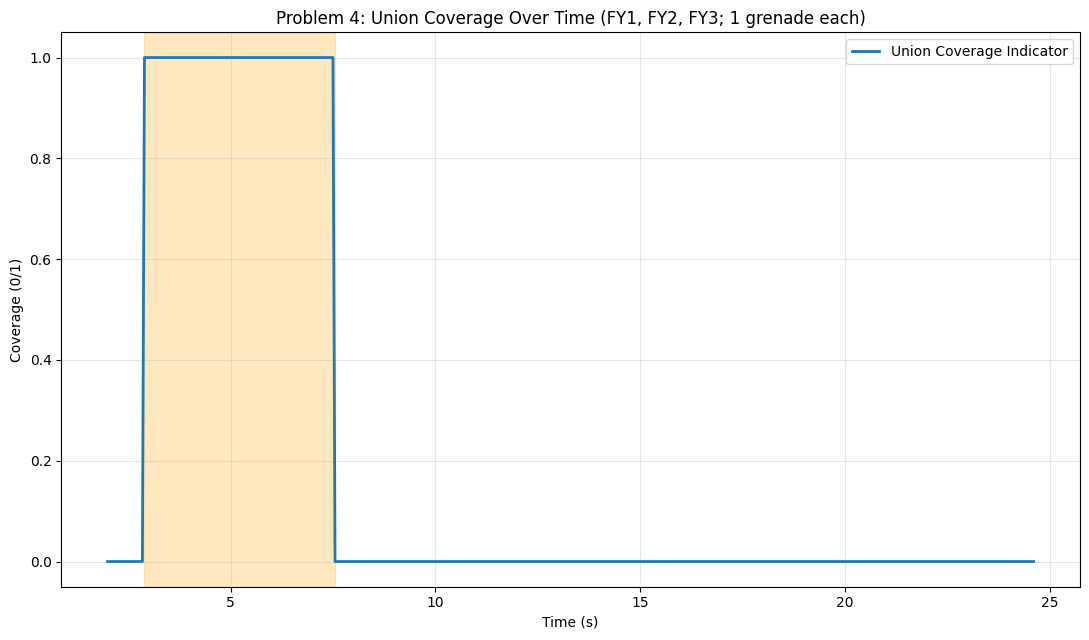

==== Problem 4 (FY1, FY2, FY3; 1 grenade each) ====
UAV  Heading (deg)  Speed (m/s)  Release Time (s)  Delay (s)  Detonation Time (s)  Detonation X (m)  Detonation Y (m)  Detonation Z (m)  Single Coverage (s)  Rank
FY1          177.0         70.0               0.0        2.4                  2.4      17632.230238          8.792441          1771.776                 4.65     1
FY2          172.0         70.0               0.0        2.0                  2.0      11861.362470       1419.484234          1380.400                 0.00     2
FY3          172.0         70.0               0.0        2.0                  2.0       5861.362470      -2980.515766           680.400                 0.00     3

--- Union Coverage Intervals ---
 Start Time (s)  End Time (s)  Duration (s)
            2.9          7.55          4.65

Total Coverage (s) ≈ 4.650


In [3]:
# -*- coding: utf-8 -*-
"""
2025 高教社杯 A 题 - 问题四
三架无人机(FY1、FY2、FY3)各投放 1 枚干扰弹的快速求解脚本
- 目标: 最大化三团云的“联合遮蔽时长”(并集测度)
- 方法: 每机先生成一批候选 (航向/速度/投放延时), 保留单机遮蔽 Top-K;
        再在三机候选选中枚举组合, 按并集遮蔽时长最大选择最优组合。
- 输出:
  1) result2.xlsx (schedule / coverage_intervals / summary)
  2) coverage_problem4.png (英文标签, 无中文)
- 备注: 代码尽量“快而准”, 不做工程化封装, 便于课堂演示与复现。
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# --- matplotlib: 英文标签 & 正常显示负号 (不使用中文字体) ---
plt.rcParams["font.family"] = ["DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False


# =========================
# 1) 题面常量 (导弹 / 目标 / 无人机)
# =========================
# 导弹 M1: 从 (20000, 0, 2000) 匀速朝“假目标(0, 0, 0)”飞行, 速度 300 m/s
MISSILE_POS0 = np.array([20000.0, 0.0, 2000.0], dtype=float)
MISSILE_SPEED = 300.0
MISSILE_TARGET_FAKE = np.array([0.0, 0.0, 0.0], dtype=float)
MISSILE_DIR = (MISSILE_TARGET_FAKE - MISSILE_POS0) / np.linalg.norm(MISSILE_TARGET_FAKE - MISSILE_POS0)

# 真目标 (圆柱体下底面圆心)
TRUE_TARGET = np.array([0.0, 200.0, 0.0], dtype=float)

# 三架无人机初始位置
FY = {
    "FY1": np.array([17800.0,    0.0, 1800.0], dtype=float),
    "FY2": np.array([12000.0, 1400.0, 1400.0], dtype=float),
    "FY3": np.array([ 6000.0,-3000.0,  700.0], dtype=float),
}

# 物理与约束
V_MIN, V_MAX = 70.0, 140.0      # 无人机速度范围
G = 9.8                         # 重力加速度
R = 10.0                        # 云团有效半径 (m)
SINK = 3.0                      # 云团下沉速度 (m/s)
VALID = 20.0                    # 云团有效时间窗 (s)
DT = 0.05                       # 时间步长 (s), 越小越准但更慢
TOP_K = 8                       # 每机保留的候选方案数量 (必剪机遮蔽时长排序)


# =========================
# 2) 几何/运动学工具函数
# =========================
def missile_positions(t_grid: np.ndarray) -> np.ndarray:
    """向量化: 时刻数组 t_grid -> 导弹位置数组 shape=(N, 3)"""
    return MISSILE_POS0[None, :] + (MISSILE_SPEED * t_grid)[:, None] * MISSILE_DIR[None, :]

def cloud_centers(t_grid: np.ndarray, det_pos: np.ndarray, t_det: float) -> np.ndarray:
    """向量化: 时刻数组 t_grid -> 云团中心数组 (仅在有效窗内有意义)"""
    z = det_pos[2] - SINK * (t_grid - t_det)
    return np.column_stack([
        np.full_like(t_grid, det_pos[0]),
        np.full_like(t_grid, det_pos[1]),
        z
    ])

def point_to_segment_dist_vec(p1: np.ndarray, p2: np.ndarray, c: np.ndarray) -> np.ndarray:
    """向量化: 点集 c(N, 3) 到线段 p1-p2 的最短距离 (逐时刻)
       p1, p2 可为 (3,) 或 (N, 3)
       返回 shape=(N,)
    """
    if p1.ndim == 1:
        p1 = np.broadcast_to(p1, c.shape)
    if p2.ndim == 1:
        p2 = np.broadcast_to(p2, c.shape)
    v = p2 - p1
    w = c - p1
    vv = np.sum(v * v, axis=1)
    vv = np.where(vv == 0.0, 1e-9, vv) # 防止除零
    s = np.sum(w * v, axis=1) / vv
    s = np.clip(s, 0.0, 1.0)
    closest = p1 + s[:, None] * v
    return np.linalg.norm(c - closest, axis=1)

def detonation_state(p0: np.ndarray, theta: float, v: float, t_rel: float, dly: float):
    """给定无人机初始 p0、航向 theta、速度 v、投放时刻 t_rel、延时 dly:
       返回起爆时刻 t_det 与起爆位置 det_pos (水平匀速、竖直自由落体)
    """
    u = np.array([np.cos(theta), np.sin(theta), 0.0], dtype=float) # 水平单位向量
    rel_pos = p0 + v * t_rel * u
    det_pos = rel_pos + v * dly * u
    det_pos[2] = rel_pos[2] - 0.5 * G * (dly ** 2)
    t_det = t_rel + dly
    return t_det, det_pos

def single_coverage_mask(t_grid: np.ndarray, t_det: float, det_pos: np.ndarray) -> np.ndarray:
    """构造单团云在 t_grid 上的遮蔽掩码 (布尔数组)
       判据: 导弹-真目标连线段到云中心的的最短距离 <= R
    """
    active = (t_grid >= t_det) & (t_grid <= t_det + VALID)
    if not np.any(active):
        return np.zeros_like(t_grid, dtype=bool)
    idx = np.where(active)[0]
    t_act = t_grid[idx]
    M = missile_positions(t_act)
    C = cloud_centers(t_act, det_pos, t_det)
    d = point_to_segment_dist_vec(M, np.broadcast_to(TRUE_TARGET, M.shape), C)
    mask = np.zeros_like(t_grid, dtype=bool)
    mask[idx] = (d <= R)
    return mask

def mask_to_intervals(t_grid: np.ndarray, mask: np.ndarray):
    """将 0/1 掩码转为 (start, end) 时间区间列表"""
    x = mask.astype(int)
    dx = np.diff(x)
    starts = t_grid[1:][dx == 1]
    ends = t_grid[1:][dx == -1]
    if len(starts) > len(ends): # 进入次数多于退出 (尾部补齐)
        ends = np.append(ends, t_grid[-1])
    if len(starts) < len(ends): # 退出次数多于进入 (头部补齐)
        starts = np.insert(starts, 0, t_grid[0])
    return list(zip(starts, ends))

def intervals_measure(intervals) -> float:
    """区间并集的测度 (时长)"""
    return float(sum(e - s for s, e in intervals))


# =========================
# 3) 每机候选生成与评估 (保留 Top-K)
# =========================
def generate_candidates_for_uav(name: str, p0: np.ndarray, k_keep: int = TOP_K):
    """
    围绕 x-方向的小角度偏转, 速度在 [70, 140], 投放 [0, 0.5, 1.0]s, 延时 [2.0~3.6]s,
    返回按“单机遮蔽时长”降序保留的前 k_keep 个候选。
    """
    base = np.pi # x-
    deg_offsets = np.array([-8.0, -5.0, -3.0, 0.0, 3.0, 5.0, 8.0]) # 轻微朝 y=0 偏转
    thetas = base + np.deg2rad(deg_offsets)
    speeds = np.linspace(V_MIN, V_MAX, 4) # 70, 93.3, 116.7, 140
    t_rels = [0.0, 0.5, 1.0]
    dlys = np.linspace(2.0, 3.6, 9)

    # 先确定全局时间网格便于公平比较
    tmp, t_min, t_max = [], np.inf, -np.inf
    for th in thetas:
        for v in speeds:
            for tr in t_rels:
                for d in dlys:
                    t_det, det_pos = detonation_state(p0, th, v, tr, d)
                    t_min = min(t_min, t_det)
                    t_max = max(t_max, t_det + VALID)
                    tmp.append((th, v, tr, d, t_det, det_pos))

    t_grid = np.arange(t_min, t_max + DT, DT)

    # 逐候选评估单机遮蔽
    cands = []
    for th, v, tr, d, t_det, det_pos in tmp:
        mask = single_coverage_mask(t_grid, t_det, det_pos)
        intervals = mask_to_intervals(t_grid, mask)
        cov = intervals_measure(intervals)
        cands.append({
            "uav": name,
            "theta": float(th), "v": float(v), "t_rel": float(tr), "dly": float(d),
            "t_det": float(t_det), "det_pos": det_pos,
            "cov": float(cov), "intervals": intervals,
            "mask": mask, "t_grid": t_grid
        })

    cands.sort(key=lambda x: x["cov"], reverse=True) # 单机时长降序
    return cands[:k_keep]

# 生成三机候选
C1 = generate_candidates_for_uav("FY1", FY["FY1"], k_keep=TOP_K)
C2 = generate_candidates_for_uav("FY2", FY["FY2"], k_keep=TOP_K)
C3 = generate_candidates_for_uav("FY3", FY["FY3"], k_keep=TOP_K)


# =========================
# 4) 穷举三机组合, 计算“并集遮蔽”并取最优
# =========================
def union_mask_on_common_grid(c1, c2, c3):
    """在公共时间网格上 重建三团遮蔽掩码并做并集"""
    t_start = min(c1["t_grid"][0], c2["t_grid"][0], c3["t_grid"][0])
    t_end = max(c1["t_grid"][-1], c2["t_grid"][-1], c3["t_grid"][-1])
    t_grid = np.arange(t_start, t_end + DT, DT)

    m1 = single_coverage_mask(t_grid, c1["t_det"], c1["det_pos"])
    m2 = single_coverage_mask(t_grid, c2["t_det"], c2["det_pos"])
    m3 = single_coverage_mask(t_grid, c3["t_det"], c3["det_pos"])
    return t_grid, (m1 | m2 | m3)

best = {"cov": -1.0}
for a in C1:
    for b in C2:
        for c in C3:
            t_grid, uni = union_mask_on_common_grid(a, b, c)
            intervals = mask_to_intervals(t_grid, uni)
            cov = intervals_measure(intervals)
            if cov > best["cov"]:
                best.update({
                    "cov": cov, "intervals": intervals, "t_grid": t_grid,
                    "cand1": a, "cand2": b, "cand3": c,
                    "union_mask": uni
                })


# =========================
# 5) 结果组装 & 落盘
# =========================
def pack_row(cand, rank_idx):
    pos = cand["det_pos"]
    return {
        "UAV": cand["uav"],
        "Heading (deg)": np.rad2deg(cand["theta"]),
        "Speed (m/s)": cand["v"],
        "Release Time (s)": cand["t_rel"],
        "Delay (s)": cand["dly"],
        "Detonation Time (s)": cand["t_det"],
        "Detonation X (m)": pos[0],
        "Detonation Y (m)": pos[1],
        "Detonation Z (m)": pos[2],
        "Single Coverage (s)": cand["cov"],
        "Rank": rank_idx
    }

schedule_df = pd.DataFrame([
    pack_row(best["cand1"], 1),
    pack_row(best["cand2"], 2),
    pack_row(best["cand3"], 3),
])

intervals_df = pd.DataFrame(best["intervals"], columns=["Start Time (s)", "End Time (s)"])
intervals_df["Duration (s)"] = intervals_df["End Time (s)"] - intervals_df["Start Time (s)"]

with pd.ExcelWriter("../result2.xlsx") as writer:
    schedule_df.to_excel(writer, index=False, sheet_name="schedule")
    intervals_df.to_excel(writer, index=False, sheet_name="coverage_intervals")
    pd.DataFrame([{"Total Coverage (s)": best["cov"]}]).to_excel(writer, index=False, sheet_name="summary")


# =========================
# 6) 可视化 (英文标签)
# =========================
plt.figure(figsize=(11, 6.5))
plt.plot(best["t_grid"], best["union_mask"].astype(int), lw=2, label="Union Coverage Indicator")
for (s, e) in best["intervals"]:
    plt.axvspan(s, e, color="orange", alpha=0.25)
plt.xlabel("Time (s)")
plt.ylabel("Coverage (0/1)")
plt.title("Problem 4: Union Coverage Over Time (FY1, FY2, FY3; 1 grenade each)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("coverage_problem4.png", dpi=300)
plt.show()


# =========================
# 7) 控制台输出 (便于快速核对)
# =========================
print("==== Problem 4 (FY1, FY2, FY3; 1 grenade each) ====")
print(schedule_df.to_string(index=False))
print("\n--- Union Coverage Intervals ---")
print(intervals_df.to_string(index=False))
print(f"\nTotal Coverage (s) ≈ {best['cov']:.3f}")
